In [1]:
import os
import math
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torchsummary import summary
from fastprogress import progress_bar

In [2]:
# define image transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# download dataset
train_dataset = torchvision.datasets.SUN397(root='dataset', transform=transform, download=True)

# # select classes
classes_idx = [idx for idx, label in enumerate(train_dataset.classes) if label in
    ['bedroom', 'beach', 'skyscraper', 'lighthouse', 'windmill', 'mountain', 'castle', 'rice_paddy', 'forest_path', 'bridge']]

# filter dataset by classes
train_dataset = torch.utils.data.Subset(train_dataset, [idx for idx, label in enumerate(train_dataset._labels) if label in classes_idx])

print('Dataset size:', len(train_dataset))

Dataset size: 8048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


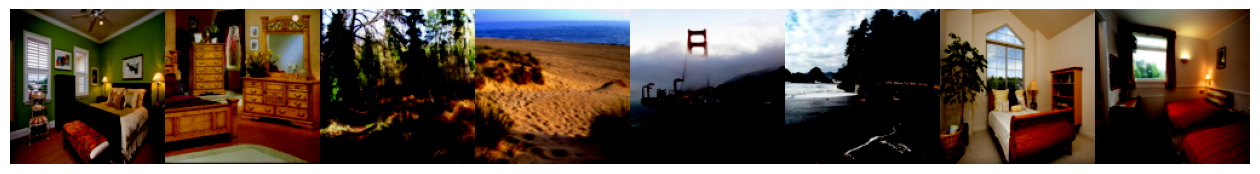

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# extract a batch of images
batch_images, batch_labels = next(iter(train_loader))
# display a grid of images
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch_images[:8], padding=0).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [4]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.group_norm_1 = torch.nn.GroupNorm(32, in_channels)
        self.conv_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.group_norm_2 = torch.nn.GroupNorm(32, out_channels)
        self.conv_2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = torch.nn.Identity()
        else:
            self.residual_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        residue = x

        x = self.group_norm_1(x)
        x = torch.nn.functional.silu(x)
        x = self.conv_1(x)

        x = self.group_norm_2(x)
        x = torch.nn.functional.silu(x)
        x = self.conv_2(x)

        return x + self.residual_layer(residue)

In [5]:
class SelfAttention(torch.nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.in_proj = torch.nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        self.out_proj = torch.nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        input_shape = x.shape
        batch_size, sequence_length, _ = input_shape
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        if causal_mask:
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)
        weight /= math.sqrt(self.d_head)
        weight = torch.nn.functional.softmax(weight, dim=-1)

        output = weight @ v
        output = output.transpose(1, 2)
        output = output.reshape(input_shape)
        output = self.out_proj(output)
        return output

In [6]:
class AttentionBlock(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.group_norm = torch.nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    
    def forward(self, x):
        residue = x
        x = self.group_norm(x)

        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        x = x.transpose(-1, -2)
        x = self.attention(x)
        x = x.transpose(-1, -2)
        x = x.view((n, c, h, w))

        x += residue
        return x

In [7]:
class Encoder(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            ResidualBlock(64, 64),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            ResidualBlock(64, 128),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            ResidualBlock(128, 256),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            ResidualBlock(256, 256),
            AttentionBlock(256),
            ResidualBlock(256, 256),
            torch.nn.GroupNorm(32, 256),
            torch.nn.SiLU(),
            torch.nn.Conv2d(256, 8, kernel_size=3, padding=1),
            torch.nn.Conv2d(8, 8, kernel_size=1, padding=0),
        )

    def forward(self, x):
        for module in self:
            if getattr(module, 'stride', None) == (2, 2):
                x = torch.nn.functional.pad(x, (0, 1, 0, 1))
            x = module(x)

        mean, log_variance = torch.chunk(x, 2, dim=1)
        log_variance = torch.clamp(log_variance, -30, 20)
        variance = log_variance.exp()
        stdev = variance.sqrt()
        noise = torch.randn(*mean.size()).float().cuda()
        x = mean + stdev * noise

        x *= 0.18215
        return mean, log_variance, x

In [8]:
encoder = Encoder().float().cuda()
z_mean, z_log_var, z = encoder(torch.rand((8, 3, 128, 128)).float().cuda())

print('Latent space shape', z_mean.shape)

Latent space shape torch.Size([8, 4, 16, 16])


In [9]:
summary(encoder, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
         GroupNorm-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
         GroupNorm-4         [-1, 64, 128, 128]             128
            Conv2d-5         [-1, 64, 128, 128]          36,928
          Identity-6         [-1, 64, 128, 128]               0
     ResidualBlock-7         [-1, 64, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
         GroupNorm-9           [-1, 64, 64, 64]             128
           Conv2d-10          [-1, 128, 64, 64]          73,856
        GroupNorm-11          [-1, 128, 64, 64]             256
           Conv2d-12          [-1, 128, 64, 64]         147,584
           Conv2d-13          [-1, 128, 64, 64]           8,320
    ResidualBlock-14          [-1, 128,

In [10]:
class Decoder(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(4, 4, kernel_size=1, padding=0),
            torch.nn.Conv2d(4, 256, kernel_size=3, padding=1),
            ResidualBlock(256, 256),
            AttentionBlock(256),
            ResidualBlock(256, 256),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            ResidualBlock(256, 256),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            ResidualBlock(256, 128),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            ResidualBlock(128, 64),
            torch.nn.GroupNorm(32, 64),
            torch.nn.SiLU(),
            torch.nn.Conv2d(64, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x /= 0.18215
        for module in self:
            x = module(x)
        return x

In [11]:
decoder = Decoder().float().cuda()
reconstruction = decoder(torch.rand((8, 4, 16, 16)).float().cuda())

print('Reconstruction shape', reconstruction.shape)

Reconstruction shape torch.Size([8, 3, 128, 128])


In [12]:
summary(decoder, input_size=(4, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 16, 16]              20
            Conv2d-2          [-1, 256, 16, 16]           9,472
         GroupNorm-3          [-1, 256, 16, 16]             512
            Conv2d-4          [-1, 256, 16, 16]         590,080
         GroupNorm-5          [-1, 256, 16, 16]             512
            Conv2d-6          [-1, 256, 16, 16]         590,080
          Identity-7          [-1, 256, 16, 16]               0
     ResidualBlock-8          [-1, 256, 16, 16]               0
         GroupNorm-9          [-1, 256, 16, 16]             512
           Linear-10             [-1, 256, 768]         197,376
           Linear-11             [-1, 256, 256]          65,792
    SelfAttention-12             [-1, 256, 256]               0
   AttentionBlock-13          [-1, 256, 16, 16]               0
        GroupNorm-14          [-1, 256,

In [13]:
EPOCHS = 100
LEARNING_RATE = 5e-3

def loss_fn(recon_x, x, mean, log_var):
    mse = torch.nn.functional.mse_loss(recon_x, x, size_average=False)
    kld = -0.5 * torch.mean(1 + log_var - torch.pow(mean, 2) - torch.exp(log_var))

    return mse + kld, mse, kld

def save_checkpoint(checkpoint_path="diffusion_vae"):
    torch.save(encoder.state_dict(), os.path.join(checkpoint_path, "encoder_ckpt.pt"))
    torch.save(decoder.state_dict(), os.path.join(checkpoint_path, "decoder_ckpt.pt"))

scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [14]:
def log_images():
    encoder.eval()
    decoder.eval()
    with torch.inference_mode():
        sample_images = batch_images.cuda()
        mean, z_log_var, z = encoder(sample_images)
        reconstructed = decoder(z)
        reconstructed = (reconstructed.clamp(-1, 1) + 1) / 2
        reconstructed = (reconstructed * 255).type(torch.uint8)

    # display a reconstructed images
    plt.figure(figsize=(16, 12))
    plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructed[:8], padding=0).cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [15]:
encoder.load_state_dict(torch.load(os.path.join("diffusion_vae", "encoder_ckpt.pt")))
decoder.load_state_dict(torch.load(os.path.join("diffusion_vae", "decoder_ckpt.pt")))

<All keys matched successfully>

/opt/conda/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/100 - total_loss: 1.02e+07, reconstruction_loss: 1.02e+07, kl_loss: 3.25e+04


Epoch 2/100 - total_loss: 9.60e+06, reconstruction_loss: 9.57e+06, kl_loss: 2.98e+04


Epoch 3/100 - total_loss: 9.36e+06, reconstruction_loss: 9.33e+06, kl_loss: 2.71e+04


Epoch 4/100 - total_loss: 9.35e+06, reconstruction_loss: 9.32e+06, kl_loss: 2.48e+04


Epoch 5/100 - total_loss: 9.25e+06, reconstruction_loss: 9.23e+06, kl_loss: 2.33e+04


Epoch 6/100 - total_loss: 9.08e+06, reconstruction_loss: 9.05e+06, kl_loss: 2.15e+04


Epoch 7/100 - total_loss: 8.98e+06, reconstruction_loss: 8.96e+06, kl_loss: 2.00e+04


Epoch 8/100 - total_loss: 8.71e+06, reconstruction_loss: 8.69e+06, kl_loss: 1.92e+04


Epoch 9/100 - total_loss: 8.60e+06, reconstruction_loss: 8.58e+06, kl_loss: 1.83e+04


Epoch 10/100 - total_loss: 8.53e+06, reconstruction_loss: 8.52e+06, kl_loss: 1.74e+04


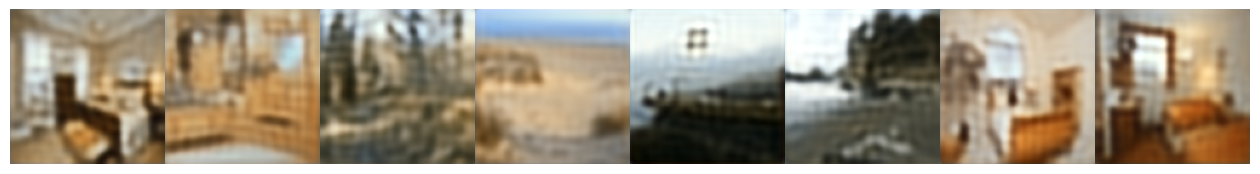

Epoch 11/100 - total_loss: 8.36e+06, reconstruction_loss: 8.34e+06, kl_loss: 1.64e+04


Epoch 12/100 - total_loss: 8.33e+06, reconstruction_loss: 8.32e+06, kl_loss: 1.54e+04


Epoch 13/100 - total_loss: 8.28e+06, reconstruction_loss: 8.26e+06, kl_loss: 1.47e+04


Epoch 14/100 - total_loss: 8.13e+06, reconstruction_loss: 8.12e+06, kl_loss: 1.41e+04


Epoch 15/100 - total_loss: 8.23e+06, reconstruction_loss: 8.21e+06, kl_loss: 1.37e+04


Epoch 16/100 - total_loss: 8.06e+06, reconstruction_loss: 8.05e+06, kl_loss: 1.32e+04


Epoch 17/100 - total_loss: 8.00e+06, reconstruction_loss: 7.99e+06, kl_loss: 1.26e+04


Epoch 18/100 - total_loss: 8.04e+06, reconstruction_loss: 8.03e+06, kl_loss: 1.23e+04


Epoch 19/100 - total_loss: 7.90e+06, reconstruction_loss: 7.89e+06, kl_loss: 1.19e+04


Epoch 20/100 - total_loss: 7.97e+06, reconstruction_loss: 7.95e+06, kl_loss: 1.17e+04


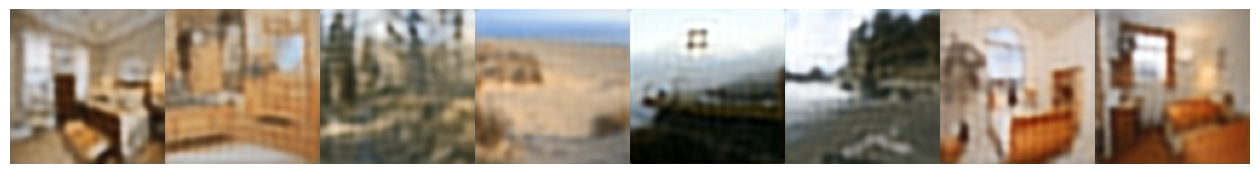

Epoch 21/100 - total_loss: 7.91e+06, reconstruction_loss: 7.90e+06, kl_loss: 1.13e+04


Epoch 22/100 - total_loss: 7.79e+06, reconstruction_loss: 7.77e+06, kl_loss: 1.09e+04


Epoch 23/100 - total_loss: 7.88e+06, reconstruction_loss: 7.87e+06, kl_loss: 1.08e+04


Epoch 24/100 - total_loss: 7.76e+06, reconstruction_loss: 7.75e+06, kl_loss: 1.05e+04


Epoch 25/100 - total_loss: 7.67e+06, reconstruction_loss: 7.66e+06, kl_loss: 1.00e+04


Epoch 26/100 - total_loss: 7.75e+06, reconstruction_loss: 7.74e+06, kl_loss: 9.91e+03


Epoch 27/100 - total_loss: 7.61e+06, reconstruction_loss: 7.60e+06, kl_loss: 9.75e+03


Epoch 28/100 - total_loss: 7.56e+06, reconstruction_loss: 7.55e+06, kl_loss: 9.82e+03


Epoch 29/100 - total_loss: 7.50e+06, reconstruction_loss: 7.49e+06, kl_loss: 9.37e+03


Epoch 30/100 - total_loss: 7.36e+06, reconstruction_loss: 7.35e+06, kl_loss: 9.00e+03


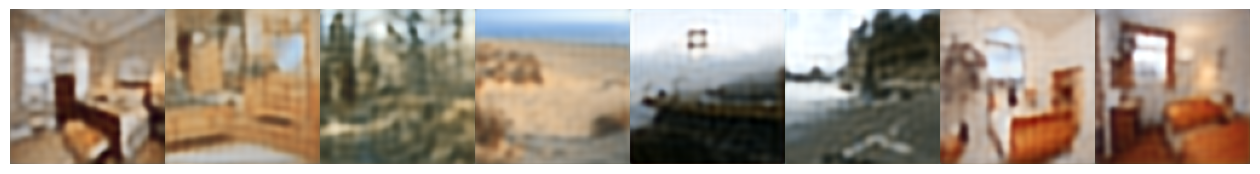

Epoch 31/100 - total_loss: 7.40e+06, reconstruction_loss: 7.39e+06, kl_loss: 8.72e+03


Epoch 32/100 - total_loss: 7.35e+06, reconstruction_loss: 7.35e+06, kl_loss: 8.46e+03


Epoch 33/100 - total_loss: 7.24e+06, reconstruction_loss: 7.23e+06, kl_loss: 8.29e+03


Epoch 34/100 - total_loss: 7.29e+06, reconstruction_loss: 7.28e+06, kl_loss: 8.00e+03


Epoch 35/100 - total_loss: 7.21e+06, reconstruction_loss: 7.20e+06, kl_loss: 7.81e+03


Epoch 36/100 - total_loss: 7.18e+06, reconstruction_loss: 7.17e+06, kl_loss: 7.84e+03


Epoch 37/100 - total_loss: 7.18e+06, reconstruction_loss: 7.17e+06, kl_loss: 7.61e+03


Epoch 38/100 - total_loss: 7.05e+06, reconstruction_loss: 7.04e+06, kl_loss: 7.37e+03


Epoch 39/100 - total_loss: 7.07e+06, reconstruction_loss: 7.06e+06, kl_loss: 7.22e+03


Epoch 40/100 - total_loss: 7.09e+06, reconstruction_loss: 7.09e+06, kl_loss: 7.08e+03


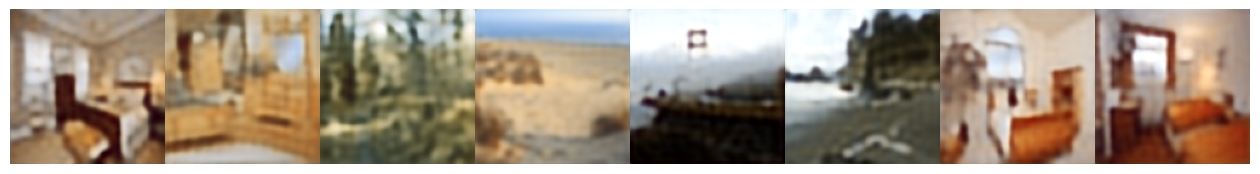

Epoch 41/100 - total_loss: 6.95e+06, reconstruction_loss: 6.94e+06, kl_loss: 7.00e+03


Epoch 42/100 - total_loss: 7.03e+06, reconstruction_loss: 7.02e+06, kl_loss: 6.88e+03


Epoch 43/100 - total_loss: 6.96e+06, reconstruction_loss: 6.95e+06, kl_loss: 6.75e+03


Epoch 44/100 - total_loss: 6.88e+06, reconstruction_loss: 6.87e+06, kl_loss: 6.68e+03


Epoch 45/100 - total_loss: 6.94e+06, reconstruction_loss: 6.93e+06, kl_loss: 6.55e+03


Epoch 46/100 - total_loss: 6.82e+06, reconstruction_loss: 6.81e+06, kl_loss: 6.44e+03


Epoch 47/100 - total_loss: 6.85e+06, reconstruction_loss: 6.84e+06, kl_loss: 6.46e+03


Epoch 48/100 - total_loss: 6.85e+06, reconstruction_loss: 6.84e+06, kl_loss: 6.34e+03


Epoch 49/100 - total_loss: 6.70e+06, reconstruction_loss: 6.70e+06, kl_loss: 6.24e+03


Epoch 50/100 - total_loss: 6.80e+06, reconstruction_loss: 6.79e+06, kl_loss: 6.13e+03


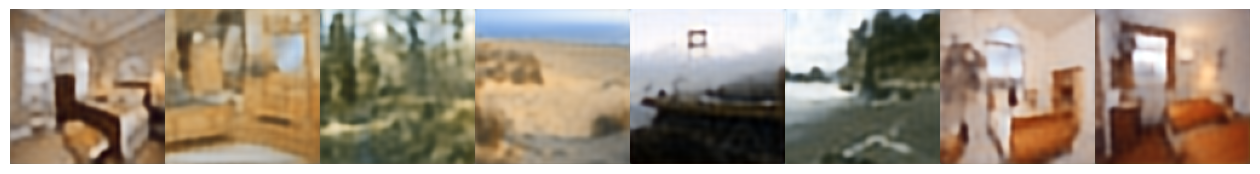

KeyboardInterrupt: 

In [17]:
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    p_bar = progress_bar(train_loader, leave=False)
    avg_loss = 0.
    avg_kl_loss = 0.
    avg_reconstruction_loss = 0.
    for image, label in p_bar:
        image = image.cuda()
        with torch.autocast("cuda") and torch.enable_grad():
            # forward pass
            z_mean, z_log_var, z = encoder(image)
            reconstruction = decoder(z)
            # calculate loss
            loss, mse, kld = loss_fn(reconstruction, image, z_mean, z_log_var)
        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        # logger
        avg_loss += loss
        avg_kl_loss += kld
        avg_reconstruction_loss += mse
        p_bar.comment = f"total_loss: {loss.item():.2e}, reconstruction_loss: {mse.item():.2e}, kl_loss: {kld.item():.2e}"
    # log average loss
    print(f"Epoch {epoch + 1}/{EPOCHS} - total_loss: {avg_loss.mean().item():.2e}, reconstruction_loss: {avg_reconstruction_loss.mean().item():.2e}, kl_loss: {avg_kl_loss.mean().item():.2e}")
    
    if (epoch + 1) % 10 == 0:
        # view reconstructed images
        log_images()
        # save checkpoint
        save_checkpoint("diffusion_vae")

In [18]:
save_checkpoint("diffusion_vae")